# Small World Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

# TODO: remove this when NetworkX is fixed
from warnings import simplefilter
import matplotlib.cbook
simplefilter("ignore", matplotlib.cbook.mplDeprecation)

In [2]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [3]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [4]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [5]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [6]:
lattice = make_ring_lattice(10, 4)

Saving figure to file figs/chap03-1


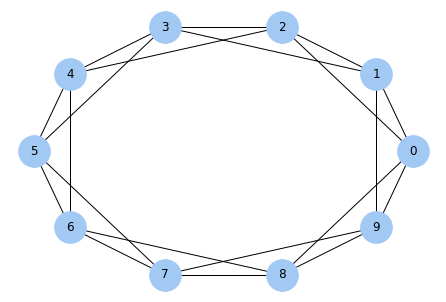

In [7]:
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

## WS graph

To make a WS graph, you start with a ring lattice and then rewire.

In [8]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [9]:
def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

In [10]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color='C1', 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [11]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

In [12]:
n = 10
k = 4
ns = 100

plt.subplot(1,3,1)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

#TODO: Set figure size
savefig('figs/chap03-2')

Saving figure to file figs/chap03-2


**Exercise:** What is the order of growth of `rewire`?

In [13]:
# It iterates through all edges, then performs set combination
# on a set of nodes and a set of edges.
# The order of growth is likely the square of the number of edges --- O(n^2)
#
# This might depend on how python is implementing set operations, and 
# whether the sets are copied elsewhere in memory before the operation is applied.

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [13]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [14]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [15]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [16]:
clustering_coefficient(lattice)

0.5

Correct.

In [17]:
%timeit clustering_coefficient(lattice)

125 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.  Is it faster?

In [18]:
# Solution goes here

def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = sum([G.has_edge(v, w) for v, w in all_pairs(neighbors)])
    return exist / possible

In [19]:
%timeit clustering_coefficient(lattice)
# It appears to be just about the same runtime

125 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [21]:
# O(n^3)... for each node, you are calculating the connectedness of each of its neighbors.
# This is an O(n) operation times an O(n^2) operation.

## Path length

The following function computes path lengths between all pairs of nodes

In [20]:
def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            yield dist

The characteristic path length is the mean path length for all pairs.

In [21]:
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

On a complete graph, the average path length should be 1

In [23]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)
# 0.9 because some nodes are themselves

0.90000000000000002

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [24]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.399999999999999

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [25]:
ring_lattice = make_ring_lattice(10, 4)
characteristic_path_length(ring_lattice)

1.5

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [26]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes a few seconds on my computer:

In [27]:
%time run_one_graph(1000, 10, 0.01)

8.09008 0.64427965368
Wall time: 6.55 s


(8.0900800000000004, 0.64427965367965367)

Now we'll run it with a range of values for `p`.

In [28]:
ps = np.logspace(-4, 0, 9)
print(ps)

[  1.00000000e-04   3.16227766e-04   1.00000000e-03   3.16227766e-03
   1.00000000e-02   3.16227766e-02   1.00000000e-01   3.16227766e-01
   1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [29]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns:
    """
    res = []
    for p in ps:
        print(p)
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print(means)
        res.append(means)
    return np.array(res)

Here are the raw results.  Warning: this takes a few minutes to run.

In [30]:
%time res = run_experiment(ps)

0.0001
40.31351 0.666278787879
50.4 0.666666666667
50.4 0.666666666667
42.709786 0.666278787879
50.4 0.666666666667
47.619372 0.666134343434
50.4 0.666666666667
49.355834 0.666206565657
40.255518 0.666134343434
50.4 0.666666666667
50.4 0.666666666667
50.4 0.666666666667
50.4 0.666666666667
39.170738 0.665674242424
37.713292 0.665674242424
50.063572 0.666278787879
50.4 0.666666666667
39.97594 0.666423232323
50.4 0.666666666667
50.4 0.666666666667
[ 47.0788781    0.66642083]
0.000316227766017
38.432042 0.666351010101
33.124508 0.66571969697
36.562402 0.665674242424
26.901408 0.665430808081
36.403226 0.665674242424
34.945936 0.665674242424
42.066476 0.666206565657
45.320244 0.665890909091
33.706618 0.665746464646
38.483334 0.666351010101
32.741306 0.665004040404
33.297916 0.666035353535
38.627748 0.666351010101
45.023802 0.666351010101
42.498028 0.666035353535
35.436 0.665767171717
43.005584 0.666206565657
37.573622 0.66617979798
46.46555 0.666351010101
45.575598 0.666278787879
[ 38.30956

In [33]:
res

array([[  4.70788781e+01,   6.66420833e-01],
       [  3.83095674e+01,   6.65963965e-01],
       [  2.72751893e+01,   6.64734823e-01],
       [  1.60586335e+01,   6.60907861e-01],
       [  8.97817750e+00,   6.47596631e-01],
       [  5.95460950e+00,   6.07592411e-01],
       [  4.41470540e+00,   4.89020531e-01],
       [  3.55176280e+00,   2.06526950e-01],
       [  3.25887540e+00,   9.50647533e-03]])

Let's get the results into a form that's easy to plot.

In [34]:
L, C = np.transpose(res)

In [35]:
L

array([ 47.0788781,  38.3095674,  27.2751893,  16.0586335,   8.9781775,
         5.9546095,   4.4147054,   3.5517628,   3.2588754])

In [36]:
C

array([ 0.66642083,  0.66596396,  0.66473482,  0.66090786,  0.64759663,
        0.60759241,  0.48902053,  0.20652695,  0.00950648])

And normalize them so they both start at 1.0

In [37]:
L /= L[0]
C /= C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

In [38]:
plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

savefig('figs/chap03-3')

Saving figure to file figs/chap03-3


## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [39]:
lattice = make_ring_lattice(10, 4)

In [40]:
nx.draw_circular(lattice, 
                 node_color='C2', 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [43]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [44]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [45]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            queue.extend(neighbors)
    return seen

It works, too.

In [46]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [113]:
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [48]:
lattice = make_ring_lattice(10, 4)

In [49]:
nx.draw_circular(lattice, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [50]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

And here's the result from NetworkX:

In [51]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

They are the same:

In [52]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [62]:
# Solution goes here

# Node 500 should be farthest away from node 0.
# Each node is connected, at, most, to a node five
# away from it; therefore, the shortest path should be 100.

lattice = make_ring_lattice(1000, 10)
d = nx.shortest_path_length(lattice, 0)
d

# I was correct; nodes 496-504 all have distances of 100.

{0: 0,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 2,
 11: 3,
 12: 3,
 13: 3,
 14: 3,
 15: 3,
 16: 4,
 17: 4,
 18: 4,
 19: 4,
 20: 4,
 21: 5,
 22: 5,
 23: 5,
 24: 5,
 25: 5,
 26: 6,
 27: 6,
 28: 6,
 29: 6,
 30: 6,
 31: 7,
 32: 7,
 33: 7,
 34: 7,
 35: 7,
 36: 8,
 37: 8,
 38: 8,
 39: 8,
 40: 8,
 41: 9,
 42: 9,
 43: 9,
 44: 9,
 45: 9,
 46: 10,
 47: 10,
 48: 10,
 49: 10,
 50: 10,
 51: 11,
 52: 11,
 53: 11,
 54: 11,
 55: 11,
 56: 12,
 57: 12,
 58: 12,
 59: 12,
 60: 12,
 61: 13,
 62: 13,
 63: 13,
 64: 13,
 65: 13,
 66: 14,
 67: 14,
 68: 14,
 69: 14,
 70: 14,
 71: 15,
 72: 15,
 73: 15,
 74: 15,
 75: 15,
 76: 16,
 77: 16,
 78: 16,
 79: 16,
 80: 16,
 81: 17,
 82: 17,
 83: 17,
 84: 17,
 85: 17,
 86: 18,
 87: 18,
 88: 18,
 89: 18,
 90: 18,
 91: 19,
 92: 19,
 93: 19,
 94: 19,
 95: 19,
 96: 20,
 97: 20,
 98: 20,
 99: 20,
 100: 20,
 101: 21,
 102: 21,
 103: 21,
 104: 21,
 105: 21,
 106: 22,
 107: 22,
 108: 22,
 109: 22,
 110: 22,
 111: 23,
 112: 23,
 113: 23,
 114: 23,
 115: 

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [89]:
# 
def make_regular_graph(n, k):
    if k%2 == 0:
        return make_ring_lattice(n, k)
    elif n%2 != 0:
        # If there are an odd number of nodes and an odd number of
        # edges per node, it's unsolveable; it would result in a
        # fractional number of edges
        raise ValueError
    elif n < k+1:
        # Each node must have at least k potential neighbors
        raise ValuError
    else:
        g = make_ring_lattice(n, k - 1)
        for i in range(0, n//2):
            g.add_edge(i, n//2+i)
        return g
        

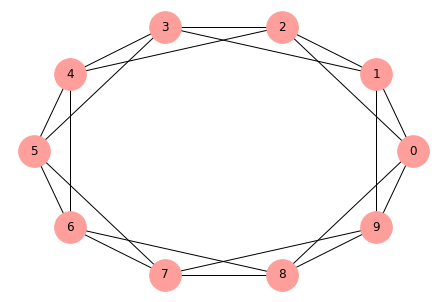

In [90]:
# Solution goes here
a = make_regular_graph(10, 4)
nx.draw_circular(a, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

In [91]:
# Solution goes here
a = make_regular_graph(10, 5)
nx.draw_circular(a, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

In [88]:
# Solution goes here
a = make_regular_graph(11, 5)
nx.draw_circular(a, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

ValueError: 

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [92]:
def plain_bfs(G, start):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [100]:
# Solution goes here
g = make_regular_graph(100000, 51)
%time plain_bfs(g, 0)
%time reachable_nodes_bfs(g, 0)
# Plain BFS seems to be a bit faster.

Wall time: 421 ms
Wall time: 927 ms


{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2, 7: 1, 8: 1}


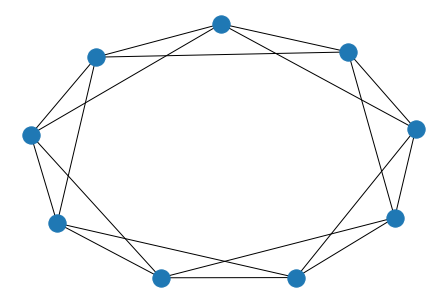

In [110]:
# Solution goes here
def plain_bfs(G, start):
    """A fast BFS node generator"""
    seen = {}
    nextlevel = {start}
    dist = 0
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen[v] = dist
                nextlevel.update(G[v])
        dist += 1
    return seen

g = make_regular_graph(9, 4)
print(plain_bfs(g, 0))
nx.draw(g)

In [58]:
# Solution goes here

In [59]:
# Solution goes here

In [60]:
# Solution goes here

In [61]:
# Solution goes here

In [62]:
# Solution goes here

In [63]:
# Solution goes here

**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [111]:
def bfs(G, start):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [start]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in G[curr_node]
                     if c not in visited and c not in queue)
    return visited

In [112]:
# 1. You are checking each step whether a node is in the queue; since
#    queue is a list, this is a linear time operation.
# 2. Popping the first element of the queue is a linear operation, since
#    items are generally added and removed from the end for maximum efficiency.
#
# The actual order of growth is O(n^3); one for the maximum number of nodes
# to visit, one for each neighbor you check, and another for checking if the
# item is in the queue.

{0, 1, 2, 3, 4, 5, 6, 7, 8}

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [120]:
# Solution goes here
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = [source]
    while queue:
        node = queue.pop()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            if n in dist:
                dist[n] = min(dist[n], new_dist)
            else:
                dist[n] = new_dist
        
        queue += [i for i in neighbors]
    return dist

In [121]:
a = make_regular_graph(12, 2)
shortest_path_dijkstra(a, 0)

{0: 0, 1: 1, 2: 10, 3: 9, 4: 8, 5: 7, 6: 6, 7: 5, 8: 4, 9: 3, 10: 2, 11: 1}